In [1]:
#import matplotlib.pyplot as plt
#%matplotlib inline
#import IPython.display
#import librosa.display
import numpy as np
import librosa
import tensorflow as tf

In [11]:
import glob
uav_path = '../data/phantom/JUNE_01_PHANTOMS/wavs/*.wav'
none_path = '../data/phantom/JUNE_02_BACKGROUND/wavs/background/background_0*.wav'
uav_files = glob.glob(uav_path)
none_files = glob.glob(none_path)
print(uav_files)
print(none_files)

['../data/phantom/JUNE_01_PHANTOMS/wavs/P1_stationary.wav', '../data/phantom/JUNE_01_PHANTOMS/wavs/P1_up_and_down.wav', '../data/phantom/JUNE_01_PHANTOMS/wavs/purdue_P2_unloaded_up_down.wav', '../data/phantom/JUNE_01_PHANTOMS/wavs/purrdue_P2_standing.wav', '../data/phantom/JUNE_01_PHANTOMS/wavs/WSU_P2_DOWN_UNLOADED.wav', '../data/phantom/JUNE_01_PHANTOMS/wavs/WSU_P2_HIGH_LOADED_DOWN.wav', '../data/phantom/JUNE_01_PHANTOMS/wavs/WSU_P2_LOADED_BACK_AND_FORTH.wav', '../data/phantom/JUNE_01_PHANTOMS/wavs/WSU_P2_LOADED_BACK_AND_FORTH_2.wav', '../data/phantom/JUNE_01_PHANTOMS/wavs/WSU_P2_LOADED_up_and_down.wav', '../data/phantom/JUNE_01_PHANTOMS/wavs/WSU_P2_UNLOADED_BACK_AND_FORTH.wav', '../data/phantom/JUNE_01_PHANTOMS/wavs/WSU_P2_UNLOADED_UP_AND_DOWN.wav']
['../data/phantom/JUNE_02_BACKGROUND/wavs/background/background_06_02_01.wav', '../data/phantom/JUNE_02_BACKGROUND/wavs/background/background_06_02_02.wav', '../data/phantom/JUNE_02_BACKGROUND/wavs/background/background_06_02_03.wav', '..

In [12]:
CHUNK_SIZE = 8192
SR = 44100
N_MFCC = 13

In [9]:
def load(files, sr=44100):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [10]:
uav_raw = load(uav_files)
none_raw = load(none_files)

(9732096,)
(18579456,)


### mfcc incremental

In [32]:
def mfcc(raw, chunk_size=8192, sr=44100, n_mfcc=13):
    mfcc = np.empty((13, 0))
    for i in range(0, len(raw), chunk_size):
        mfcc_slice = librosa.feature.mfcc(raw[i:i+chunk_size], sr=sr, n_mfcc=n_mfcc)
        mfcc = np.hstack((mfcc, mfcc_slice))
    return mfcc

In [33]:
mfcc_uav = mfcc(uav_raw)
mfcc_none = mfcc(none_raw)

In [34]:
print(mfcc_uav.shape)
print(mfcc_none.shape)

(13, 20196)
(13, 38556)


In [36]:
# or should we give one label to one chunk?
y_uav = np.ones(mfcc_uav.shape[1], dtype=int)
y_none =np.zeros(mfcc_none.shape[1], dtype=int)

print(y_uav.shape)
print(y_none.shape)

(20196,)
(38556,)


In [37]:
X = np.hstack((mfcc_uav, mfcc_none)).T
y = np.hstack((y_uav, y_none))
print(X.shape, y.shape)

(58752, 13) (58752,)


In [22]:
n_labels = y.shape[0]
n_unique_labels = 2
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1
print(y_encoded.shape)

(55296, 2)


In [23]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [24]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(44236, 13) (11060, 13)
(44236, 2) (11060, 2)


In [25]:
np.save('../data/Xy/X_train2', X_train)
np.save('../data/Xy/X_test2', X_test)
np.save('../data/Xy/y_train2', y_train)
np.save('../data/Xy/y_test2', y_test)

In [2]:
X_train = np.load('../data/Xy/X_train2.npy')
X_test = np.load('../data/Xy/X_test2.npy')
y_train = np.load('../data/Xy/y_train2.npy')
y_test = np.load('../data/Xy/y_test2.npy')

# Tensorflow finally!

## Training

### Parameters
- need feedback on this!

In [26]:
n_dim = 13 #X_train.shape[1]
n_classes = 2
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [27]:
training_epochs = 100

In [28]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.global_variables_initializer()

In [29]:
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [30]:
print(X_train.shape, y_train.shape)

(44236, 13) (44236, 2)


In [31]:
model_path = '../models/my_test_model'
saver = tf.train.Saver()

In [32]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:X_train,Y:y_train})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: X_test})
    y_true = sess.run(tf.argmax(y_test,1))
    saver.save(sess, model_path)

### Below is for later when testing with pretrained model

In [34]:
with tf.Session() as sess:
    #sess.run(init)
    saver.restore(sess, model_path)
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: X_test})
    y_true = sess.run(tf.argmax(y_encoded,1))

FailedPreconditionError: Attempting to use uninitialized value Variable_1
	 [[Node: Variable_1/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable_1)]]

Caused by op 'Variable_1/read', defined at:
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-ca25dc90989d>", line 5, in <module>
    b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 235, in __init__
    constraint=constraint)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 397, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 142, in identity
    return gen_array_ops.identity(input, name=name)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3187, in identity
    "Identity", input=input, name=name)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/Users/bowonyang/anaconda3/envs/thesis/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable_1
	 [[Node: Variable_1/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable_1)]]


## Results
- Batch training and batch testing

#### epoch=3200

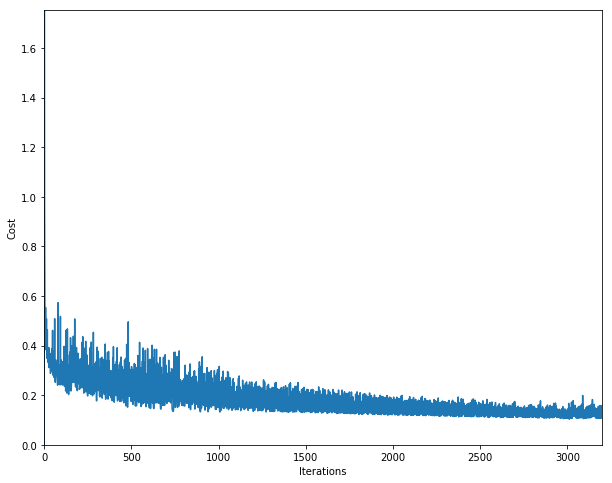

F-Score: 0.962
Accuracy:  0.9622061482820976
             precision    recall  f1-score   support

          0       0.99      0.96      0.97      7253
          1       0.92      0.97      0.95      3807

avg / total       0.96      0.96      0.96     11060

[[6931  322]
 [  96 3711]]


In [9]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

#### epoch=1600

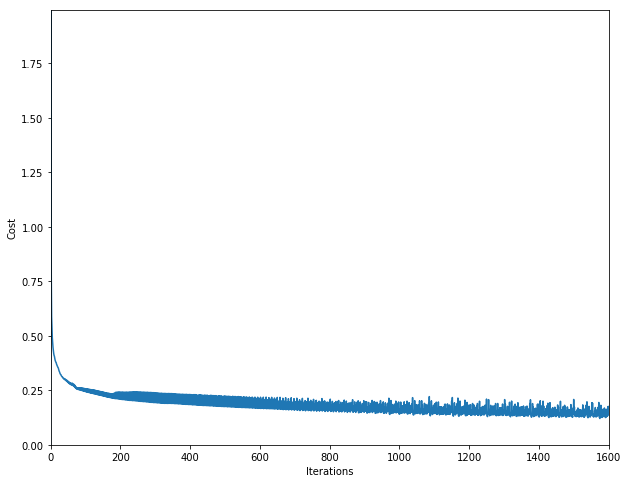

F-Score: 0.956
Accuracy:  0.9559674502712477
             precision    recall  f1-score   support

          0       0.97      0.96      0.97      7253
          1       0.93      0.95      0.94      3807

avg / total       0.96      0.96      0.96     11060

[[6971  282]
 [ 205 3602]]


In [11]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

#### epoch=800

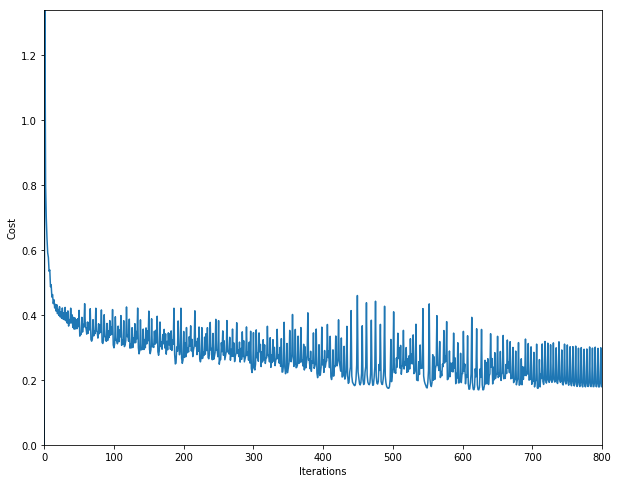

F-Score: 0.942
Accuracy:  0.941500904159132
             precision    recall  f1-score   support

          0       0.97      0.94      0.95      7253
          1       0.89      0.95      0.92      3807

avg / total       0.94      0.94      0.94     11060

[[6788  465]
 [ 182 3625]]


In [10]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

#### epoch=400

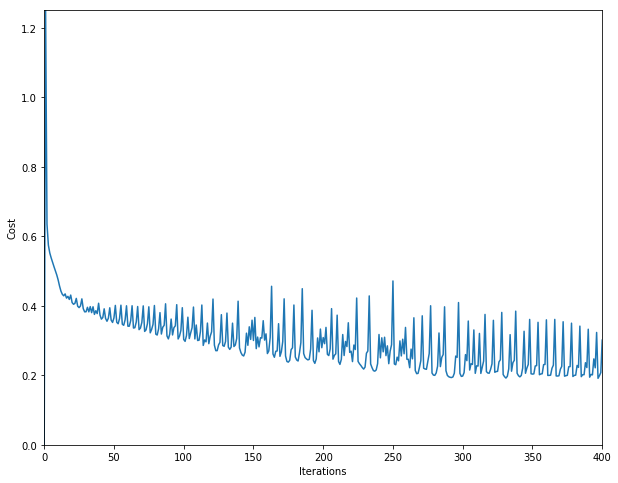

F-Score: 0.941
Accuracy:  0.9411392405063291
             precision    recall  f1-score   support

          0       0.96      0.95      0.96      7253
          1       0.91      0.92      0.91      3807

avg / total       0.94      0.94      0.94     11060

[[6925  328]
 [ 323 3484]]


In [9]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

#### epoch=200

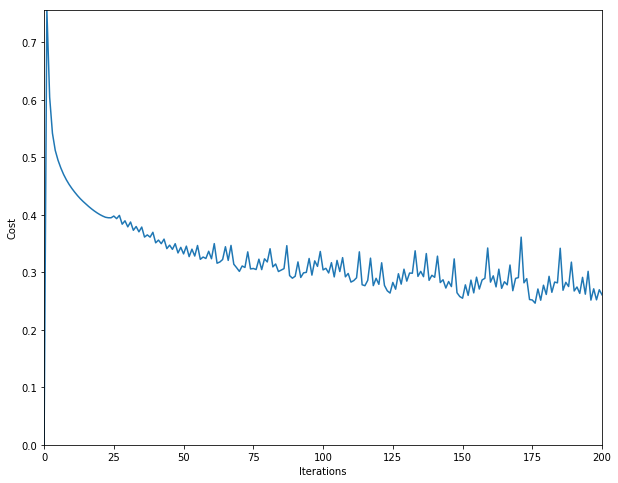

F-Score: 0.88
Accuracy:  0.8802893309222423
             precision    recall  f1-score   support

          0       0.85      0.99      0.92      7253
          1       0.97      0.67      0.80      3807

avg / total       0.89      0.88      0.87     11060

[[7168   85]
 [1239 2568]]


In [13]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

#### epoch=100

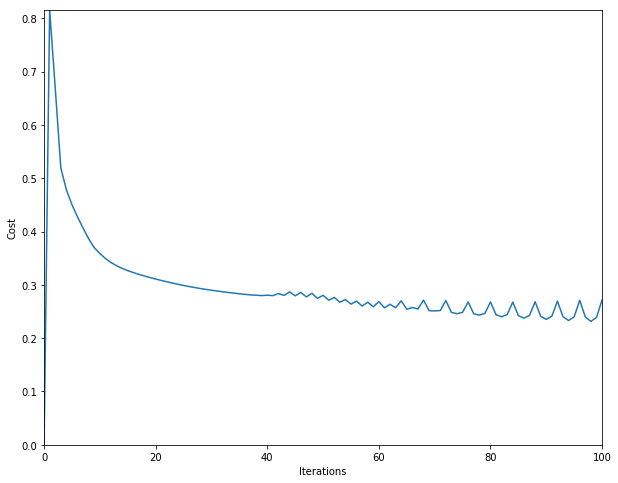

F-Score: 0.929
Accuracy:  0.9290235081374322
             precision    recall  f1-score   support

          0       0.93      0.96      0.95      7253
          1       0.92      0.87      0.89      3807

avg / total       0.93      0.93      0.93     11060

[[6968  285]
 [ 500 3307]]


In [11]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

#### epoch=20

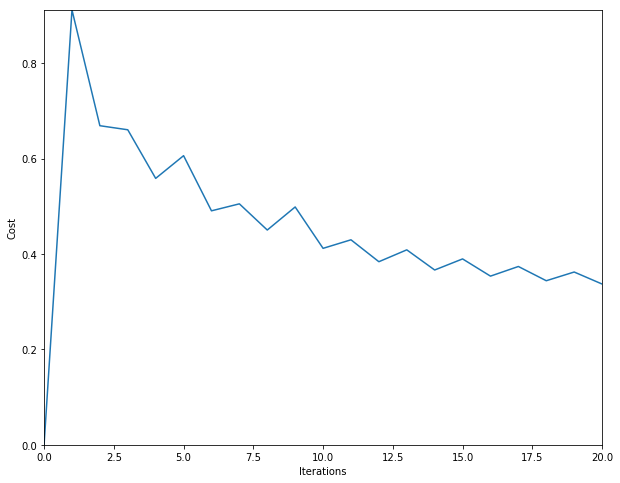

F-Score: 0.845
Accuracy:  0.8446654611211574
             precision    recall  f1-score   support

          0       0.82      0.99      0.89      7253
          1       0.96      0.57      0.72      3807

avg / total       0.86      0.84      0.83     11060

[[7155   98]
 [1620 2187]]


In [34]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))